# Classify text with BERT

# Setup


We use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
# First install all necessary packages

!pip install torch
!pip install transformers

Looking in indexes: https://pypi.python.org/simple/
  Using cached torch-1.11.0-cp38-cp38-manylinux1_x86_64.whl (750.6 MB)
Looking in indexes: https://pypi.python.org/simple/
  Using cached transformers-4.19.2-py3-none-any.whl (4.2 MB)
  Using cached filelock-3.7.0-py3-none-any.whl (10 kB)
  Using cached tokenizers-0.12.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Using cached regex-2022.4.24-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (764 kB)
  Using cached numpy-1.22.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.9 MB)
  Using cached huggingface_hub-0.6.0-py3-none-any.whl (84 kB)


In [4]:
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install official

Looking in indexes: https://pypi.python.org/simple/
  Using cached pandas-1.4.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Using cached pytz-2022.1-py2.py3-none-any.whl (503 kB)
Looking in indexes: https://pypi.python.org/simple/
  Using cached matplotlib-3.5.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.33.3-py3-none-any.whl (930 kB)
  Using cached Pillow-9.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached kiwisolver-1.4.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
Looking in indexes: https://pypi.python.org/simple/
  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-1.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached scipy-1.8.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41

In [5]:
import os
import shutil

from utils import load_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import metrics, model_selection, preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
# from official.nlp import optimization  # to create AdamW optimizer


In [6]:
import sys
sys.path.insert(1, '/home/jovyan/workbench-shared-folder/workbench-shared-folder/canary-project/Paula_internship/')

### Load the dataset


In [7]:
# DATA_PATH = "../data/"
DATA_PATH = "/home/jovyan/workbench-shared-folder/canary-project/Paula_internship/data/"

# Load data from Set A, B and EX
train_A, test_A, val_A = load_data(DATA_PATH, version="A", suffix="_kw", reduce_memory=True)
train_B, test_B, val_B = load_data(DATA_PATH, version="B", suffix="_kw", reduce_memory=True)
train_EX, test_EX, val_EX = load_data(DATA_PATH, version="EX", suffix="_kw", reduce_memory=True)

Mem. usage decreased to  4.83 Mb (83.6% reduction)
Mem. usage decreased to  2.42 Mb (83.6% reduction)
Mem. usage decreased to  0.81 Mb (83.6% reduction)
Set A with suffix '_kw' was loaded successfully.
Mem. usage decreased to  5.18 Mb (83.6% reduction)
Mem. usage decreased to  2.59 Mb (83.6% reduction)
Mem. usage decreased to  0.86 Mb (83.6% reduction)
Set B with suffix '_kw' was loaded successfully.


/home/jovyan/workbench-shared-folder/canary-project/Paula_internship/utils.py:46: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train = pd.read_csv(f"{path}set_{version}_train{suffix}.csv", engine='python', error_bad_lines=False)
Skipping line 157634: unexpected end of data
/home/jovyan/workbench-shared-folder/canary-project/Paula_internship/utils.py:47: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test = pd.read_csv(f"{path}set_{version}_test{suffix}.csv", engine='python', error_bad_lines=False)
/home/jovyan/workbench-shared-folder/canary-project/Paula_internship/utils.py:48: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  val = pd.read_csv(f"{path}set_{version}_val{suffix}.csv", engine='python', error_bad

Mem. usage decreased to 10.82 Mb (83.6% reduction)
Mem. usage decreased to  5.42 Mb (83.6% reduction)
Mem. usage decreased to  1.81 Mb (83.6% reduction)
Set EX with suffix '_kw' was loaded successfully.


In [43]:
#We concatenate the 3 different sets (A, B, EX):

train = pd.concat([train_A, train_B, train_EX])
test = pd.concat([test_A, test_B, test_EX])
val = pd.concat([val_A, val_B, val_EX])

# BERT Classifier using PyTorch

### Define useful classes

In [34]:
class Dataset:
    '''
    Dataset class to map indices/keys of data samples. Implemented __getitem__() and __len__() protocols.
    Using the tokenizer, the inputs are mapped to BERT ids/mask.
    '''
    
    def __init__(self, texts, labels, tokenizer, max_len, truncate):
        self.texts = texts
        self.labels = labels

        self.tokenizer = tokenizer
        self.max_len = max_len
        self.truncation = truncate
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        inputs = self.tokenizer.__call__(text,
                                        None,
                                        add_special_tokens=True,
                                        max_length=self.max_len,
                                        padding="max_length",
                                        truncation=self.truncation,
                                        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [35]:
class Classifier(nn.Module):
    '''
    The actual NN used for classification
    '''
    def __init__(self, n_train_steps, n_classes, do_prob, bert_model):
        super(Classifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(do_prob)
        self.out1 = nn.Linear(768, 256)
        self.out2 = nn.Linear(256, n_classes)
        self.n_train_steps = n_train_steps
        self.step_scheduler_after = "batch"

    def forward(self, ids, mask):
        output_1 = self.bert(ids, attention_mask=mask)["pooler_output"]
        output_2 = self.dropout(output_1)
        output_3 = F.relu(self.out1(output_2))
        output = F.softmax(self.out2(output_3))
        return output

In [ ]:
# # Define which BERT we are using:

# # SPECTER: Document-level Representation Learning using Citation-informed Transformers
# tokenizer = transformers.AutoTokenizer.from_pretrained("allenai/specter", do_lower_case=True)
# bert_model = transformers.AutoModel.from_pretrained("allenai/specter")

# # SCIBERT: BERT model trained on scientific text.
# tokenizer = transformers.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)
# bert_model = transformers.AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')


# # SQUEEZE BERT: 
# tokenizer = transformers.SqueezeBertTokenizer.from_pretrained("squeezebert/squeezebert-uncased", do_lower_case=True)
# bert_model = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")

In [36]:
# FREEZE BERT PARAMS OR FINE-TUNE?
tokenizer = transformers.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)
bert_model = transformers.AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

for param in bert_model.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
n_labels = train.iloc[:, 3:].shape[1]

def build_dataset(tokenizer_max_len, truncate):
    '''
    Tokenize and map the training and validation sets
    '''
    train_dataset = Dataset(train.input.tolist(), train.iloc[:, 3:].values.tolist(), tokenizer, tokenizer_max_len, truncate)
    valid_dataset = Dataset(val.input.tolist(), val.iloc[:, 3:].values.tolist(), tokenizer, tokenizer_max_len, truncate)
    
    return train_dataset, valid_dataset

def build_dataloader(train_dataset, valid_dataset, batch_size):
    '''
    Create the torch dataloaders
    '''
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

    return train_data_loader, valid_data_loader

def get_classWeigths():
    
    train_labels = train.iloc[:, 3:]
    tot = sum(train_labels.sum(axis=0))
    weight = 1 - (train_labels.sum(axis=0) / tot)
    
    return torch.tensor(weight)

def ret_model(n_train_steps, do_prob):
    '''
    Retrieve the model
    '''
    model = Classifier(n_train_steps, n_labels, do_prob, bert_model=bert_model)
    return model


In [ ]:
def ret_optimizer(model):
    '''
    Taken from Abhishek Thakur's Tez library example: 
    https://github.com/abhishekkrthakur/tez/blob/main/examples/text_classification/binary.py
    '''
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
#     opt = AdamW(optimizer_parameters, lr=config['learning_rate'])
    opt = torch.optim.AdamW(optimizer_parameters, lr=config['learning_rate'])
    return opt

def ret_scheduler(optimizer, num_train_steps):
    sch = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)
    return sch

def loss_function(outputs, labels, weights, loss='BCE'):
    if labels is None:
        return None
    if loss == 'BCE':
        # BinaryCross Entropy loss
        loss_fn = nn.BCEWithLogitsLoss()
        return loss_fn(outputs, labels.float())
    elif loss == 'SigF1':
#         S=-1
#         E=0
#         y_hat = torch.sigmoid(outputs)
#         y = labels
#         # Sigmoid hyperparams:
#         b = torch.tensor(S)
#         c = torch.tensor(E)

#         # Calculate the sigmoid
#         sig = 1 / (1 + torch.exp(b * (y_hat + c)))
        sig = outputs
        tp = torch.sum(sig * y, dim=0)
        fp = torch.sum(sig * (1 - y), dim=0)
        fn = torch.sum((1 - sig) * y, dim=0)

        sigmoid_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
        cost = 1 - sigmoid_f1
        macroCost = torch.mean(cost)

        return macroCost
    
    elif loss == 'SigF1_weighted':
        # Sigmoid hyperparams:
        b = torch.tensor(S)
        c = torch.tensor(E)

        # Calculate the sigmoid
        sig = 1 / (1 + torch.exp(b * (y_hat + c)))
        tp = torch.sum(sig * y, dim=0)
        fp = torch.sum(sig * (1 - y), dim=0)
        fn = torch.sum((1 - sig) * y, dim=0)

        sigmoid_f1 = 2*tp / (2*tp + fn + fp + 1e-16)

        cost = 1 - sigmoid_f1
        weighted_cost = cost * weights
        macroCost = torch.mean(weighted_cost)
        
    else:
        # BinaryCross Entropy loss
        loss_fn = nn.BCEWithLogitsLoss()
    
        return loss_fn(outputs, labels.float())

def log_metrics(preds, labels):
    preds = torch.stack(preds)
    preds = preds.cpu().detach().numpy()
    labels = torch.stack(labels)
    labels = labels.cpu().detach().numpy()
    
    '''
    auc_micro_list = []
    for i in range(n_labels):
      current_pred = preds.T[i]
      current_label = labels.T[i]
      fpr_micro, tpr_micro, _ = metrics.roc_curve(current_label.T, current_pred.T)
      auc_micro = metrics.auc(fpr_micro, tpr_micro)
      auc_micro_list.append(auc_micro)
    
    return {"auc": np.array(auc_micro).mean()}
    '''
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
    fpr_micro, tpr_micro, _ = metrics.roc_curve(labels.ravel(), preds.ravel())
    
    auc_micro = metrics.auc(fpr_micro, tpr_micro)
    return {"auc_micro": auc_micro}

### Define the training and evaluation functions

In [56]:
from tqdm.notebook import tqdm

def train_fn(data_loader, model, loss_fn, optimizer, device, scheduler, weights):
    '''
        Modified from Abhishek Thakur's BERT example: 
        https://github.com/abhishekkrthakur/bert-sentiment/blob/master/src/engine.py
        
        Gradient scaling:
        https://pytorch.org/docs/stable/amp.html#gradient-scaling
    '''
    scaler = torch.cuda.amp.GradScaler()
    
    train_loss = 0.0
    model.train()
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        mask = d["mask"]
        targets = d["labels"]

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask)
        with torch.cuda.amp.autocast():
            loss = loss_function(outputs, targets, weights, loss_fn)
#         loss.backward()
        scaler.scale(loss).backward()
        train_loss += loss.item()
#         optimizer.step()
        scaler.step(optimizer)
#         scheduler.step()
        scaler.update()

    return train_loss
    

def eval_fn(data_loader, model, loss_fn, weights, device):
    '''
        Modified from Abhishek Thakur's BERT example: 
        https://github.com/abhishekkrthakur/bert-sentiment/blob/master/src/engine.py
    '''
    eval_loss = 0.0
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            mask = d["mask"]
            targets = d["labels"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask)
            loss = loss_function(outputs, targets, weights, loss_fn)
            eval_loss += loss.item()
            fin_targets.extend(targets)
            fin_outputs.extend(torch.sigmoid(outputs))
    return eval_loss, fin_outputs, fin_targets

## Train the network

In [44]:
def trainer(config):

    train_dataset, valid_dataset = build_dataset(config['tokenizer_max_len'], config['truncate'])
    train_data_loader, valid_data_loader = build_dataloader(train_dataset, valid_dataset, config['batch_size'])
    print("Length of Train Dataloader: ", len(train_data_loader))
    print("Length of Valid Dataloader: ", len(valid_data_loader))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    weights = get_classWeigths()

    n_train_steps = int(len(train_dataset) / config['batch_size'] * 10)

    model = ret_model(n_train_steps, config['dropout'])
    optimizer = ret_optimizer(model)
    scheduler = ret_scheduler(optimizer, n_train_steps)
    model.to(device)
    model = nn.DataParallel(model)
    
    n_epochs = config['epochs']
    loss_fn = config['loss']
    
    train_losses = []
    eval_losses = []

    best_val_loss = 100
    for epoch in tqdm(range(n_epochs)):
        print('Train EPOCH: ', epoch+1)
        train_loss = train_fn(train_data_loader, model, loss_fn, optimizer, device, scheduler, weights)
        eval_loss, preds, labels = eval_fn(valid_data_loader, model, loss_fn, weights, device)
        
        metrics_eval = log_metrics(preds, labels)
        try:
            auc_score  = metrics_eval["auc_micro"]
#             print("AUC score: ", auc_score)
        except:
            pass
        avg_train_loss, avg_val_loss = train_loss / len(train_data_loader), eval_loss / len(valid_data_loader)
        
        train_losses.append(avg_train_loss)
        eval_losses.append(avg_val_loss)
        
        print("Average Train loss: ", avg_train_loss)
        print("Average Valid loss: ", avg_val_loss)
        torch.save(model.state_dict(), "./models/model_current_freeze_512_2laySM.pt")  

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "./models/model_best_freeze_512_2laySM_"+ str(epoch+1) +".pt")  
            print("Model saved as current val_loss is: ", best_val_loss) 
            
    return train_losses, eval_losses

Set some configuration parameters (to be fine-tuned)

In [45]:
config = {
    'learning_rate': 1e-5,
    'batch_size': 32,
    'epochs': 10,
    'dropout': 0.5,
    'tokenizer_max_len': 512,
    'truncate': True,
#     'loss': 'BCE',
    'loss': 'SigF1',
}

In [46]:
# Train the model:

train_loss, eval_loss = trainer(config)

# Save the losses
loss_epochs = pd.DataFrame([train_loss, eval_loss]).rename(index={0: "Train loss", 1: "Eval loss"}).T
loss_epochs.to_csv('outputs/loss_epochs_sci512_2layDrop_freeze_F1.csv')

Length of Train Dataloader:  9486
Length of Valid Dataloader:  1583


  0%|          | 0/10 [00:00<?, ?it/s]

Train EPOCH:  1


  0%|          | 0/9486 [00:00<?, ?it/s]

/tmp/ipykernel_94/4219592962.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.out2(output_3))
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

  0%|          | 0/1583 [00:00<?, ?it/s]

Average Train loss:  0.6893645346466308
Average Valid loss:  0.6893883424323342
Model saved as current val_loss is:  0.6893883424323342
Train EPOCH:  3


  0%|          | 0/9486 [00:00<?, ?it/s]

/tmp/ipykernel_94/4219592962.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.out2(output_3))
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1583 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1583 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Average Train loss:  0.6882661926502571
Average Valid loss:  0.6877116723596786
Model saved as current val_loss is:  0.6877116723596786
Train EPOCH:  6


  0%|          | 0/9486 [00:00<?, ?it/s]

/tmp/ipykernel_94/4219592962.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.out2(output_3))
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

  0%|          | 0/1583 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1583 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Average Train loss:  0.6878622996890039
Average Valid loss:  0.6874271035194397
Model saved as current val_loss is:  0.6874271035194397


In [ ]:
eval_loss

In [52]:
loss_epochs
# loss_epochs.plot( kind = 'line')

,Train loss,Eval loss
0,0.000073,0.000435
1,0.000073,0.000435
2,0.000073,0.000435
3,0.000073,0.000435
4,0.000073,0.000434
5,0.000073,0.000434
6,0.000073,0.000434
7,0.000073,0.000434
8,0.000073,0.000434
9,0.000073,0.000434


<AxesSubplot:>

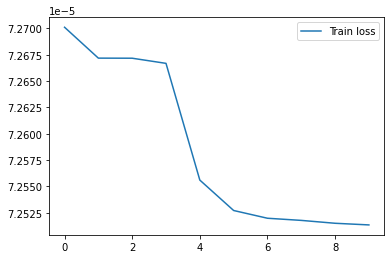

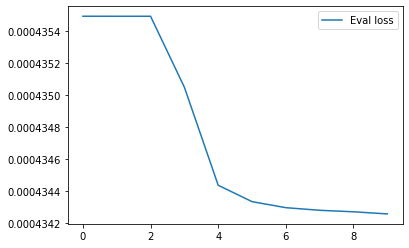

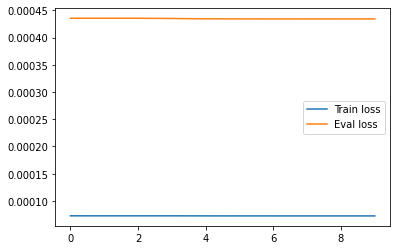

In [50]:
loss_epochs_avg = loss_epochs

# train_dataset, valid_dataset = build_dataset(config['tokenizer_max_len'], config['truncate'])
# train_data_loader, valid_data_loader = build_dataloader(train_dataset, valid_dataset, config['batch_size'])

# loss_epochs_avg['Train loss'] = loss_epochs_avg['Train loss']/len(train_data_loader)
# loss_epochs_avg['Eval loss'] = loss_epochs_avg['Eval loss']/len(valid_data_loader)

loss_epochs_avg.plot(y = 'Train loss')
loss_epochs_avg.plot(y = 'Eval loss')
loss_epochs_avg.plot()

## Define some functions for the inference

In [57]:
def load_model(model_name):
    '''
    Load a saved model
    '''
    train_dataset, valid_dataset = build_dataset(config['tokenizer_max_len'], config['truncate'])
    train_data_loader, valid_data_loader = build_dataloader(train_dataset, valid_dataset, config['batch_size'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    n_train_steps = int(len(train_dataset) / config['batch_size'] * 10)

    model = ret_model(n_train_steps, config['dropout'])
    optimizer = ret_optimizer(model)
    scheduler = ret_scheduler(optimizer, n_train_steps)
    model.to(device)
    model = nn.DataParallel(model)

    Models_PATH = "/home/jovyan/workbench-shared-folder/canary-project/Paula_internship/models/"
    model.load_state_dict(torch.load(Models_PATH + model_name, map_location=device))
    
    return model

In [58]:
def inference_batches(test, model):
    '''
    Predict outputs for inference phase
    '''
    test_targets = []
    test_outputs = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    test_dataset = Dataset(test.input.tolist(), test.iloc[:, 3:].values.tolist(), tokenizer, config['tokenizer_max_len'], config['truncate'])
    data_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2)

    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            mask = d["mask"]
            labels = d["labels"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            labels = labels.to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask)
            test_targets.extend(labels.cpu().numpy())
            test_outputs.extend(torch.sigmoid(outputs).cpu().numpy())


    return test_outputs, test_targets

In [59]:
def remove_duplicates():
    '''
    Remove duplicates of train/val datasets present in the test set
    '''
    # Get the training duplicates:
    duplicates_train = set(test.pui) & set(train.pui) 
    test_clean = test[~test['pui'].isin(duplicates_train)]
    
    # Get the validation duplicates:
    duplicates_val = set(test.pui) & set(val.pui) 
    test_clean = test_clean[~test_clean['pui'].isin(duplicates_val)]
    
    assert test_clean.shape[0] == test.shape[0] - len(duplicates_train) - len(duplicates_val)
    
    return test_clean

In [60]:
def get_metrics(preds, labels):
    '''
    Create some metrics: precison, recall, F1...
    
    A macro-average will compute the metric independently for each class and then take the average hence 
    treating all classes equally, whereas a micro-average will aggregate the contributions of all classes
    to compute the average metric.
    '''
    
    # Convert the lists to dataframes
    lab_df = pd.DataFrame(labels)
    pred_df = pd.DataFrame(preds).round(0).astype(int) # Threshold 0.5! 
    
    # Calculate tp/fp/fn/tn per class:
    tp = (pred_df + lab_df).eq(2).sum()
    fp = (pred_df - lab_df).eq(1).sum()
    fn = (pred_df - lab_df).eq(-1).sum()
    tn = (pred_df + lab_df).eq(0).sum()
    
    # Calculate precision and recall:
    prec = [tp[i] / (tp[i] + fp[i]) if tp[i] + fp[i] != 0 else 0.0 for i in range(len(tp))]
    rec = [tp[i] / (tp[i] + fn[i]) if tp[i] + fn[i] != 0 else 0.0 for i in range(len(tp))]
    
    # Calculate F1 score:
    f1_score = [2 * prec[i] * rec[i] / (prec[i] + rec[i]) if tp[i] > 0 else 0.0 for i in range(len(tp))]
    
    # Weighted F1 score:
    weight = lab_df.sum() / sum(lab_df.sum())
    f1_wght = [weight[i] * 2 * prec[i] * rec[i] / (prec[i] + rec[i]) if tp[i] > 0 else 0.0 for i in range(len(tp))]
    
    # Macro average (average over classes):
    prec_avg = sum(prec) / len(prec)
    rec_avg = sum(rec) / len(rec)
    f1_avg = sum(f1_score) / len(f1_score)
    f1wgt_avg = sum(f1_wght)
    
    # Micro scores (treat all samples together):
    tp_mic = sum(tp)
    tn_mic = sum(tn)
    fp_mic = sum(fp)
    fn_mic = sum(fn)
    prec_mic = tp_mic / (tp_mic+fp_mic)
    rec_mic = tp_mic / (tp_mic+fn_mic)
    f1_mic = (2*prec_mic*rec_mic) / (prec_mic+rec_mic)
    
    return {
        'Precision': prec, 'Recall': rec, 'F1 score': f1_score,
        'weights': weight, 'Weighted F1 score': f1_wght,
        'Macro precision': prec_avg.round(2), 'Macro recall': rec_avg.round(2), 'Macro F1 score': f1_avg.round(2),
        'Weighted F1 score': f1wgt_avg.round(2),
        'CM TP': tp, 'CM FP': fp,'CM FN': fn, 'CM TN': tn,
        'Micro Precision': round(prec_mic, 2), 'Micro Recall': round(rec_mic, 2), 'Micro F1 score': round(f1_mic, 2),
    }

# all_metrics = get_metrics(preds, labels)

In [27]:
# pd.DataFrame(preds).to_csv('outputs/Finetune/predictions.csv')
# pd.DataFrame(labels).to_csv('outputs/Finetune/labels.csv')

## Inference:

In [ ]:
# Predict outputs:
test_clean = remove_duplicates()
model = load_model('model_best_freeze_512_2laySM_10.pt')
preds, labels = inference_batches(test_clean, model)
all_metrics = get_metrics(preds, labels)

  0%|          | 0/494 [00:00<?, ?it/s]

/tmp/ipykernel_94/4219592962.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.out2(output_3))


In [62]:
all_metrics = get_metrics(preds, labels)

for metr, val in all_metrics.items():
    if 'Micro' in metr or 'Macro' in metr:
        print(metr, val)

Macro precision 0.11
Macro recall 0.06
Macro F1 score 0.06
Micro Precision 0.62
Micro Recall 0.31
Micro F1 score 0.41


In [67]:
#Save outputs:
pd.DataFrame(preds).to_csv('outputs/EXP10_TestPreds.csv')
pd.DataFrame(preds).to_csv('outputs/Test_labels.csv')

<AxesSubplot:>

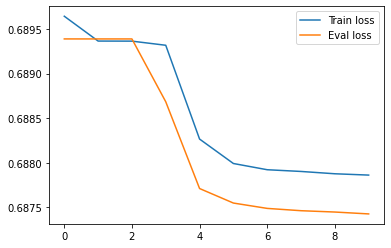

In [71]:
losses = pd.read_csv('outputs/EXP10_Losses.csv').drop(columns=['Unnamed: 0'])
losses.plot()

In [63]:
all_metrics['CM TP']
cm_df = pd.DataFrame([all_metrics['CM TP'], all_metrics['CM FP'], all_metrics['CM TN'], all_metrics['CM FN']*100]).rename(index={0: "TP", 1: "FP", 2: "TN", 3: "FN"}).T
cm_df.to_csv('outputs/EXP10_ConfMatrix.csv')

metrics_df = pd.DataFrame([all_metrics['Precision'], all_metrics['Recall'], all_metrics['F1 score'], all_metrics['weights']*100]).rename(index={0: "Precision", 1: "Recall", 2: "F1", 3: "Weights"}).T
# metrics_df = metrics_df.rename(index={0: "x", 1: "y", 2: "z"})
metrics_df.to_csv('outputs/EXP10_ClassMetrics.csv')
metrics_df

,Precision,Recall,F1,Weights
0,0.802107,1.000000,0.890188,12.519180
1,0.608428,0.995115,0.755147,9.492444
2,0.198261,0.002763,0.005450,5.102014
3,0.219462,0.004129,0.008105,3.174493
4,0.036613,0.001718,0.003282,1.151394
5,0.067114,0.004209,0.007922,0.881227
6,0.020642,0.001900,0.003479,0.585836
7,0.137255,0.003416,0.006666,2.280284
8,0.105386,0.007337,0.013720,0.758322
9,0.052632,0.002545,0.004855,1.020205
